# Local Spatial Autocorrelation

In the previous chapter we explored the use of global measures of spatial autocorrelation to ask the question of whether the overall spatial distribution of our attribute of interest was reflective of a geographically random process, or not. These statistics are useful as the presence of spatial autocorrelation has important implications for subsequent statistical analysis. From a substantive perspective, spatial autocorrelation could reflect the operation of processes that generate association between the values in nearby locations. In these cases formal modeling of the spatial dimensions of the processes should next be carried out. On the other hand, spatial autocorrelation can sometimes arise from data processing operations in which cases the dependence is a form of non-random noise rather than due to substantive processes. Irrespective of whether the spatial autocorrelation is due to substantive or nuisance sources, it is a form of non-randomness that complicates statistical anaylsis.

For these reasons the ability to determine whether  spatial autocorrelation is present in a geographically referenced data set is a critical component of the spatial data science toolbox. That said, the global measures of spatial autocorrelation are "whole map" statistics, meaning that the single statistic pertains to the complete data set. In other words, global autocorrelation statistics allow us to detect *clustering* in a geographically referenced dataset. For example,
Moran's I is good tool to summarize a dataset into a single value that informs about its degree of geographical clustering. However, it is not an appropriate measure to identify areas within the map where specific types of values (e.g. high, low) are located. In other words, Moran's I can tell us values are clustered overall, but it will not inform us about where the *clusters* are. For that purpose, we need to use a local measure of spatial autocorrelation. Local measures consider each single observation and operate on them, as oposed to on the overall dataset, as global measures do. Because of that, they are not good at summarizing a map, but they allow to obtain further insights about interesting geographical subsets of the data. In this chapter, we consider Local Indicators of Spatial Association (LISAs), a local counter-part of global measures like Moran's I. 



## An empirical illustration: the EU Referendum

We continue with the same dataset we examined in the previous chapter, and thus we utilize the same imports and initial data preparation steps:

In [1]:
# Display graphics within the notebook
%matplotlib inline

import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn                   # Graphics
import geopandas                 # Spatial data manipulation
import pandas                    # Tabular data manipulation
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
import contextily                # Background tiles
# Stamen Terrain Background tiles
from contextily.tile_providers import ST_TERRAIN_BACKGROUND
from booktools import choropleth

/opt/conda/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
ref = pandas.read_csv('../data/brexit_vote.csv', 
                      index_col='Area_Code')
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
id                         382 non-null int64
Region_Code                382 non-null object
Region                     382 non-null object
Area                       382 non-null object
Electorate                 382 non-null int64
ExpectedBallots            382 non-null int64
VerifiedBallotPapers       382 non-null int64
Pct_Turnout                382 non-null float64
Votes_Cast                 382 non-null int64
Valid_Votes                382 non-null int64
Remain                     382 non-null int64
Leave                      382 non-null int64
Rejected_Ballots           382 non-null int64
No_official_mark           382 non-null int64
Voting_for_both_answers    382 non-null int64
Writing_or_mark            382 non-null int64
Unmarked_or_void           382 non-null int64
Pct_Remain                 382 non-null float64
Pct_Leave                  382 non-null float64
Pct

Now let us bring in the spatial data:

In [3]:
lads_path = ('../data/'\
             'Local_Authority_Districts_December_2016_'\
             'Generalised_Clipped_Boundaries_in_the_UK_WGS84/'\
             'Local_Authority_Districts_December_2016_Generalised_'\
             'Clipped_Boundaries_in_the_UK_WGS84.shp')
lads = geopandas.read_file(lads_path)\
                .set_index('lad16cd')
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
objectid      391 non-null int64
lad16nm       391 non-null object
lad16nmw      22 non-null object
bng_e         391 non-null int64
bng_n         391 non-null int64
long          391 non-null float64
lat           391 non-null float64
st_areasha    391 non-null float64
st_lengths    391 non-null float64
geometry      391 non-null object
dtypes: float64(4), int64(3), object(3)
memory usage: 33.6+ KB


And to "trim" the `DataFrame` so it only retains what we know we will need:

In [4]:
db = geopandas.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)\
              .to_crs(epsg=3857)\
              [['objectid', 'lad16nm', 'Pct_Leave', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
objectid     380 non-null int64
lad16nm      380 non-null object
Pct_Leave    380 non-null float64
geometry     380 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 14.8+ KB


Although there are several variables that could be considered, we will focus on `Pct_Leave`, which measures the proportion of votes for the Leave alternative. For convenience, let us merge this with the spatial data and project the output into the Spherical Mercator coordinate reference system (CRS), which will allow us to combine them with contextual tiles.

In [5]:
lads.crs

{'init': 'epsg:4326'}

Throughout the chapter, we will rely heavily on geovisualizations. To create more useful maps that bring geographical context to the spatial distribution of votes, we will use an image made up of tiles from a web map. Let us first download it on-the-fly. The image will be reused later on in several maps.

In [6]:
# Bounding box of the polygon layer
we, so, ea, no = db.total_bounds
# Download image and extent at zoom 6
img, ext = contextily.bounds2img(we, so, ea, no, 6,
                         url=ST_TERRAIN_BACKGROUND)
# License text
lic = ("Map tiles by Stamen Design, under CC BY 3.0. "\
               "Data by OpenStreetMap, under ODbL.")

And with this elements, we can generate a choropleth to get a quick sense of the spatial distribution of the data we will be analyzing. Note how we use some visual tweaks (e.g. transparency through the `alpha` attribute) to make the final plot easier to read.

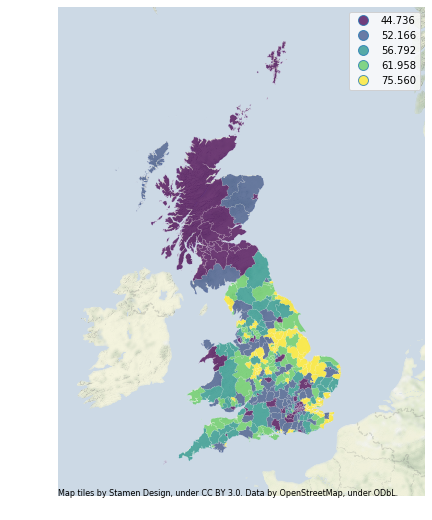

In [7]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.imshow(img, extent=ext, alpha=0.5)
choropleth(db, column='Pct_Leave', cmap='viridis', scheme='quantiles',
           k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)
plt.text(ext[0],ext[2], lic, size=8)
ax.set_axis_off()

The final piece we need before we can delve into spatial autocorrelation is the spatial weights matrix. We will use eight nearest neighbors for the sake of comparison with the previous chapter. We also row-standardize the weights:

In [8]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'

### Motivating Local Spatial Autocorrelation

To better understand the underpinning of local autorocorrelation, we will return to the Moran Plot as a graphical tool. Let us first calculate the spatial lag of our variable of interest:

In [9]:
db['w_Pct_Leave'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

And their respective standardized versions, where we substract the average and divide by the standard deviation:

In [10]:
db['Pct_Leave_std'] = ( db['Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()
db['w_Pct_Leave_std'] = ( db['w_Pct_Leave'] - db['w_Pct_Leave'].mean() )\
                    / db['w_Pct_Leave'].std()

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot in Python:

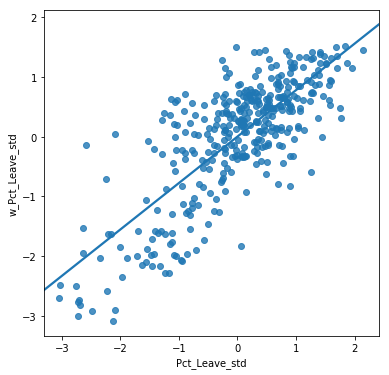

In [11]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Display
plt.show()

Using standardised values allows us to divide each variable (the percentage that voted to leave, and its spatial lag) in two groups: above and below the average. This, in turn, divides a Moran Plot in four quadrants, depending on whether a given area displays a value above the mean (high) or below (low), and how its spatial lag behaves:

* High-high (HH)
* Low-high (LH)
* Low-low (LL)
* High-low (HL)

Graphically, this can be captured as follows:

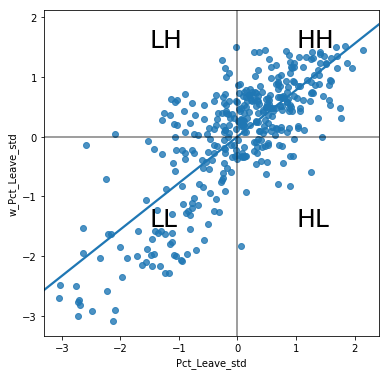

In [12]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

### Local Moran's I

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations is a *statistically significant* cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high.

This is exactly what LISAs are designed to do. A more detailed description of their statistical underpinnings is beyond the scope in this context, but we will provide some intuition about how they work. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as many statistics as original observations. The formal representation of the statistic can be written as:

$$
I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}
$$

where $m_2$ is the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$, $w_{i,j}$ is the spatial weight for the pair of observations $i$ and $j$, and $n$ is the number of observations.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work. For that, they have a prime place in the exploratory toolbox. Examples of contexts where LISAs can be useful include: identification of spatial clusters of poverty in regions, detection of ethnic enclaves, delineation of areas of particularly high/low activity of any phenomenon, etc.

**We should come up with a consistent citation and bibliography scheme. When do we cite, when do we not cite, and when we do, how?**

In Python, we can calculate LISAs in a very streamlined way thanks to `PySAL`:

In [13]:
lisa = esda.moran.Moran_Local(db['Pct_Leave'], w)

All we need to pass is the variable of interest -proportion of Leave votes in this context- and the spatial weights that describes the neighborhood relations between the different areas that make up the dataset. This creates a lisa object that has a number of attibutes of interest. The local indicators themselves are in the `Is` attribute and we can get a sense of their distribution using seaborn:

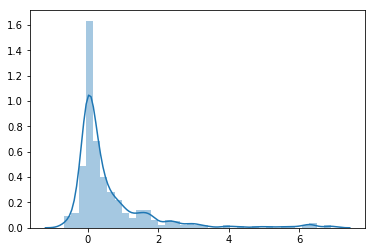

In [14]:
seaborn.distplot(lisa.Is)

This reveals a rather skewed distribution due to the dominance of the positive forms of spatial association. Here it is important to keep in mind that the high positive values arise from value simularity in space, and this can be due to either high values being next to high values *or* low values next to low values. The local $I_i$ values themselves cannot distinguish between these two.

The values in the left tail of the density represent locations displaying negative spatial association. There are also two forms, a high value surrounded by low values, or a low value surrounded by high valued neighboring observations. And, again, the  $I_i$ value cannot distinguish between the two cases.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember we are calculating a statistic for every single observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. In this context, a choropleth can help. At first glance, this may seem to suggest that a map of the $I_i$  values would be a useful way to visualize the spatial distribution:

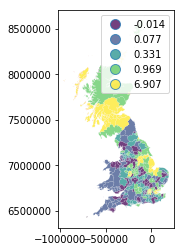

In [15]:
db['Is'] = lisa.Is
choropleth(db, column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True);

However, this does not inform us in any way about what type of spatial correlation each area is experiencing. For example, are the yellow areas in Scotland similar to those in the East cluster of high values too? Also, we know that values around zero will not be statistically significant. Which ones are thus significant and non-significant from a statistical point of view? In other words, which ones can be considered statistical clusters and which ones noise? To answer these questions, we need to bring in additional information that we have obtained when calculating the LISA statistics. Let us first build a four-plot figure that brings all these different perspectives together:

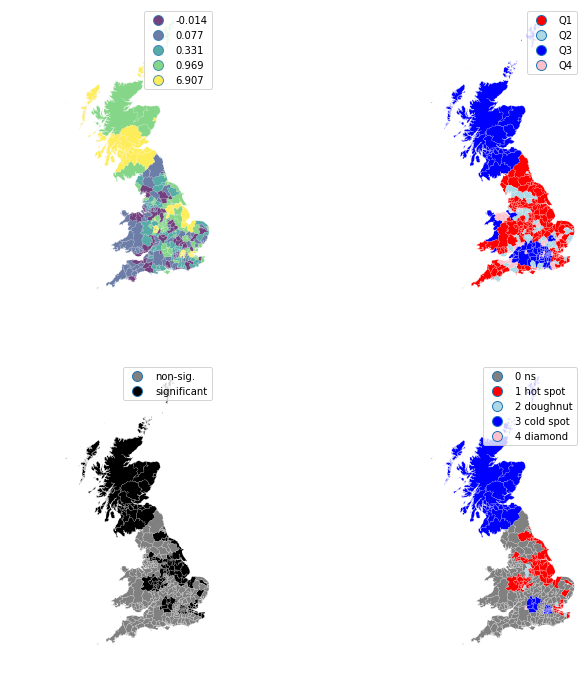

In [16]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
choropleth(db, column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)
ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()
                            
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'grey', 'red', 'lightblue', 'blue', 'pink'])


db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()


# Display the figure
plt.show()

The figure in the upper-left replicates our first map above. The green and yellow locations have the largest values for the local statistics, yet this does not distinguish between positive association of low support for the Brexit vote and positive association of high support for Brexit.

To distinguish between these two cases, the map in the upper-right shows the location of the LISA statistic in the quadrant of the Moran Scatter plot, which is recorded in the `q` attribute:


In [17]:
lisa.q[:10]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1])

The correspondence between the numbers in the `q` attribute and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL



Comparing the two maps in the top row reveals that the positive association in the north is due to low support for the Brexit vote, while the positive association in the south is of the high-support for Brexit. Overall, we can obtain counts of areas in each quadrant:

In [18]:
counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
counts

[(1, 181), (2, 51), (3, 112), (4, 36)]

Showing that the high-high (1), and low-low (3), values are predominant.

Care must be taken, however, in the interpretation of these first two maps, as the underlying statistical signifcance of the local values has not been considered.

Instead, what is typically done is to create a map, a cluster map as it is usually called, that extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object we have created above. But, to make the map making more straightforward, it is convenient to pull them out and insert them in the main data table:

In [19]:
sig = 1 * (lisa.p_sim < 0.05)
db['p-sim'] = lisa.p_sim
db['sig'] = sig
db[['sig','p-sim']].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.014
E06000002,1,0.007
E06000003,1,0.017
E06000004,1,0.014
E06000010,1,0.011


In [20]:
db[['sig','p-sim']].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.482
W06000019,0,0.481
W06000021,0,0.273
W06000022,0,0.365
W06000023,0,0.291


Thus, the first five values are statistically significant, while the last five observations are not.

Let us stop for second on these two steps. First, the `significant` column. Similarly as with global Moran's I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran's I, we select 5% as the threshold for statistical significance. To identify these values, we create a variable, `significant`, that contains `True` if the p-value of the observation satisfies the condition, and `False` otherwise. We can check this is the case:

Next we consider the `q` attribute signifying what quadrant the local value is, but now mask these values using are newly created signficance indicator:

In [21]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']

We also give descriptive labels to the five cases, where the locations with non-significant p-values for the LISAs are labeled as `ns`. Positive forms of local spatial autocorrelation are of two types: significant HH clustering, or so called 'hot spot's, or significant clustering of LL values, or 'cold spot's. Locations with significant, but negative, local autocorrelation are either 'doughnut's where a low value is neighbored by locations with high support for Brexit, or 'diamonds in the rough' where a high value is surrounded by low values.


In [22]:
db['labels'] = labels
[(spot_label, (db['labels']==spot_label).sum()) for spot_label in spot_labels]

[('0 ns', 222),
 ('1 hot spot', 77),
 ('2 doughnut', 6),
 ('3 cold spot', 71),
 ('4 diamond', 4)]

The final cluster map in the lower right above displays the output of the LISA statistics for the percentage of Leave votes in English, Welsh and Scottish local authorities. In bright red, we find those with an unusual concentration of high Leave proportions surrounded also by high Leave results. This corresponds with areas in the East and center of the map. In light red, we find the first type of spatial outliers: areas that still voted to Leave in high proportions, despite being surrounded by areas with more modest support for Leave. These correspond with some of the peripheral areas of London and and adjacent to Oxford. In darker blue we can see the spatial clusters of low support for the Leave campaign, which include London, Oxford and most of Scotland. Finally, in light blue we find the other type of spatial outlier: areas with lower percentages of Leave votes nearby areas of high concentration of supporters for Leave.

### Other local indices

Similar to the global case, there are more local indicators of spatial correlation than the local Moran's I. `PySAL` includes Getis and Ord's $G_i$ and $G_i^*$, which differ only on whether to exclude the self-value in the calculation or not, respectively. The way to calculate them also follows similar patterns as with the LISA above. Let us see how that would look like for our Brexit example:

In [23]:
# Gi
gostats = esda.getisord.G_Local(db['Pct_Leave'], w)
# Gi*
gostars = esda.getisord.G_Local(db['Pct_Leave'], w, star=True)

As the local statistics they are, it is best to explore them by plotting them on a map. Unlike with LISA though, the $G$ statistics only allow to identify positive spatial autocorrelation. When standardized, positive values imply clustering of high values, while negative implies grouping of low values. Unfortunately, it is not possible to discern spatial outliers.

In this case, let us write a little function that generates the map so we can then easily use it to generate two maps, one for $G_i$ and one for $G_i^*$:

In [24]:
def g_map(g, geog, img, ext, ax):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    img    : ndarray
             Image for background
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot background map
    ax.imshow(img, extent=ext, alpha=0.5)
    # Plot non-significant clusters
    ns = db.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='grey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='red', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='blue', edgecolor=ec, linewidth=0.1)
    # Style and draw
    st = ''
    if g.star:
        st = '*'
    ax.set_title('G%s statistic for Pct of Leave votes'%st, size=15)
    ax.set_axis_off()
    return ax

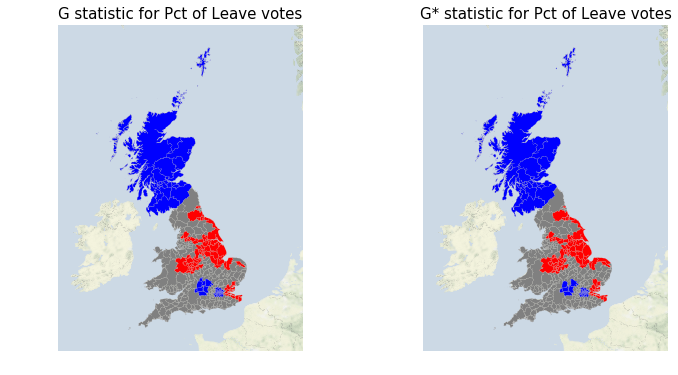

In [25]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics and generate the map
for g, ax in zip([gostats, gostars], axs.flatten()):
    ax = g_map(g, db, img, ext, ax)
# Render
plt.show()

As you can see, the results are virtually the same for $G_i$ and $G_i^*$. Also, at first glance, these maps appear to be visually similar to the final LISA map from above, and this leads to the question of why use the $G$ statistics at all. The answer to this question is that the two sets of local statistics, Local $I$ and the local $G$, are complementary statistics. This is because the local $I$ by itself cannot distinguish between the two forms of positive spatial association while the G can. At the same time, the G statistic does not consider negative spatial association, while the local I statistic does.

# Questions
1. Do the same Local Moran analysis done for `Pct_Leave`, but using `Pct_Turnout`. Is there a geography to how involved people were in different places? Where was turnout percentage (relatively) higher or lower? 
2. Do the same Getis-Ord analysis done for `Pct_Leave`, but using `Pct_Turnout`. 
3. Local Moran statistics are premised on a few distributional assumptions. One well-recognized concern with Moran statistics is when they are estimated for *rates*. Rate data is distinct from other kinds of data because it embeds the relationship between two quantities: the event and the population. For instance, in the case of Leave voting, the "event" is a person voting leave, and the "population" could be the number of eligible voters, the number of votes cast, or the total number of people. This usually only poses a problem for analysis when the event outcome is somehow dependent on the population. 
    1. Using our past analytical steps, build a new `db` dataframe from `ref` and `lads` that contains the `Electorate`, `Votes_Cast`, and `Leave` columns. 
    - From this new dataframe, make scatterplots of:
       - the number of votes cast and the percent leave vote
       - the size of the electorate and the percent of leave vote
    2. Based on your answers to the previous point, does it appear that there is a relationship between the event and the population size? Use `scipy.stats.kendalltau` or `scipy.stats.pearsonr`  to confirm your visual intuition. 
        3. Using `esda.moran.Moran_Rate`, estimate a global Moran's I that takes into account the rate structure of `Pct_Leave`, using the `Electorate` as the population. Is this estimate different from the one obtained without taking into account the rate structure? What about when `Votes_Cast` is used for the population? 
    4. Using `esda.moran.Moran_Local_Rate`, estimate *local* Moran's I treating Leave data as a rate.
        - does any site's local I change? Make a scatterplot of the `lisa.Is` you estimated before and this new rate-based local Moran. 
        - does any site's local I change their outlier/statistical significance classifications? Use `pandas.crosstab` to examine how many classifications change between the two kinds of statistic. Make sure to consider observations' statistical significances in addition to their quadrant classification.
    5. Make two maps, side by side, of the local statistics without rate correction and with rate correction. Does your interpretation of the maps change depending on the correction?
4. Local statistics use *permutation-based* inference for their significance testing. This means that, to test the statistical significance of a local relationship, values of the observed variable are *shuffled* around the map. These large numbers of *random* maps are then used to compare against the observed map. Local inference requires some restrictions on how each shuffle occurs, since each observation must be "fixed" and compared to randomly-shuffle neighboring observations. The distribution of local statistics for each "shuffle" is contained in the `.rlisas` attribute of a Local Moran object. 
    - For the first observation, make a `seaborn.distplot` of its shuffled local statistics. Add a vertical line to the histogram using `plt.axvline()`. 
    - Do the same for the last observation as well. 
    - Looking only at their permutation distributions, do you expect the first LISA statistic to be statistically-significant? Do you expect the last?
5. LISAs have some amount of fundamental uncertainty due to their estimation. This is called the `standard error` of the statistic.
    - The standard errors are contained in the `.seI_sim` attribute. Make a map of the standard errors. Are there any areas of the map that appear to be more uncertain about their local statistics? 
    - compute the standard deviation of each observation's "shuffle" distribution, contained in the `.rlisas` attribute. Verify that the standard deviation of this shuffle distribution is the same as the standard errors in `seI_sim`. 
6. Local Getis-Ord statistics come in two forms. As discussed above, Getis-Ord $G_i$ statistics *omit* each site from their own local statistic. In contrast, $G_i^*$ statistics *include* the site in its own local statistic.
    - Make a scatterplot of the two types of statistic, contained in `gostats.Zs` and `gostars.Zs` to examine how similar the two forms of the Getis-Ord statistic are. 
    - The two forms of the Getis-Ord statistic differ by their inclusion of the *site* value, $y_i$, in the value for the $G_i$ statistic at that site. So, make a scatterplot of the percent leave variable and the *difference* of the two statistics. Is there a relationship between the percent leave vote and the difference in the two forms of the Getis-Ord statistic? Confirm this for yourself using `scipy.stats.kendalltau` or `scipy.stats.pearsonr`. 

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.